In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
import time

from IPython import display
tf.__version__, keras.__version__, np.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.10.0', '2.10.0', '1.23.5', True)

In [3]:
# Loading the dataset:
batch_size = 32
def load_data(path = os.path.join("images"), batch = batch_size):
    data = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        label_mode = None,
        shuffle = True,
        image_size = (100, 100),
    )
    data = data.unbatch()
    data = data.shuffle(10000).batch(batch, drop_remainder = True)
    for i in data:
        i /= 255.
    return data

In [4]:
x_train = load_data()

Found 63565 files belonging to 1 classes.


## Models:

In [5]:
# Creating a generator:
coding_size = 100
def make_generator(coding_size = coding_size):
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(25*25*256, use_bias = False, input_shape = [coding_size]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((25, 25, 256)))
    assert model.output_shape == (None, 25, 25, 256)

    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 25, 25, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = "same", use_bias = False))
    assert model.output_shape == (None, 50, 50, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Conv2DTranspose(3, (5, 5), strides = (2, 2), padding = "same", use_bias = True, activation = 'tanh'))
    assert model.output_shape == (None, 100, 100, 3)

    return model

In [6]:
# Creating an discriminator:
from keras import layers
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[100, 100, 3], activation = 'selu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation = 'selu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
# Creating a GAN:
generator = make_generator()
discriminator = make_discriminator_model()
gan = tf.keras.models.Sequential([
    generator,
    discriminator
])

## Loss Functions and Optimizers:

In [8]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [9]:
# Creating an discriminator:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_fn(tf.ones_like(real_output), real_output)
    fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
    total = real_loss + fake_loss
    return total

In [10]:
# Creating an generator loss:
def generator_loss(fake_output):
    return loss_fn(tf.ones_like(fake_output), fake_output)

In [11]:
# Optimizers:
gen_optim = tf.keras.optimizers.Nadam(1e-4)
dis_optim = tf.keras.optimizers.Nadam(1e-4)

In [12]:
# Callbacks:
dir = os.path.join("checkpoint")
callback = tf.train.Checkpoint(generator_optimizer = gen_optim,
                               discriminator_optimizer = dis_optim,
                               generator = generator,
                               discriminator = discriminator)

# Training Looping

In [13]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optim.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    dis_optim.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      callback.save(file_prefix = dir)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [16]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

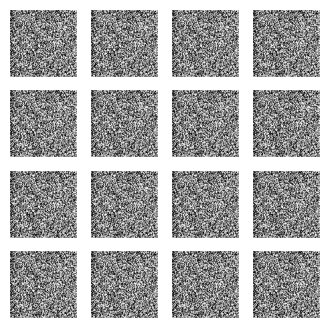

Time for epoch 1 is 68.25329184532166 sec


In [17]:
train(x_train, EPOCHS)

In [ ]:
callback.restore(tf.train.latest_checkpoint(dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)